<a href="https://colab.research.google.com/github/deborahdjon/CA683_Group_Project/blob/main/Workbooks/Chicago_Crime_Records_KNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [1]:
# Install any required packages.
!pip install -U -q PyDrive

In [2]:
# Import any required libraries.
from google.colab import auth
from patsy import dmatrices
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [3]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [5]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' })
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')

In [6]:
# Clear the downloaded file and all other variables from memory, once we've converted it to a data frame.
del downloaded_file, drive, gauth

# **Pre-Processing the data**

In [7]:
#Drop duplicates if there are any
chicago_crime_records.drop_duplicates(inplace=True)

In [8]:
# Take a look at all of the columns in our dataset.
chicago_crime_records.columns.sort_values()

Index(['Arrest', 'Beat', 'Block', 'Case Number', 'Community Area', 'Date',
       'Description', 'District', 'Domestic', 'FBI Code', 'ID', 'IUCR',
       'Latitude', 'Location', 'Location Description', 'Longitude',
       'Primary Type', 'Updated On', 'Ward', 'X Coordinate', 'Y Coordinate',
       'Year'],
      dtype='object')

In [9]:
chicago_crime_records.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [10]:
# Remove any columns that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = ['Case Number', 'Date', 'Description', 'ID', 'Updated On', 'Year'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [11]:
# Take a look at all of the columns left in our dataset.
chicago_crime_records.columns.sort_values()

Index(['Arrest', 'Beat', 'Block', 'Community Area', 'District', 'Domestic',
       'FBI Code', 'IUCR', 'Latitude', 'Location', 'Location Description',
       'Longitude', 'Primary Type', 'Ward', 'X Coordinate', 'Y Coordinate'],
      dtype='object')

In [12]:
chicago_crime_records['Primary Type'].nunique()

36

In [13]:
#Encoding our columns
chicago_crime_records['Arrest'] = chicago_crime_records['Arrest'].astype(int)
chicago_crime_records['Domestic'] = chicago_crime_records['Domestic'].astype(int)

#chicago_crime_records['Location Description_CODE'] = chicago_crime_records['Location Description'].astype('category').cat.codes

#chicago_crime_records['Block_CODE']=chicago_crime_records['Block'].astype('category').cat.codes

#chicago_crime_records['Community Area']=chicago_crime_records['Community Area'].astype(int)
#chicago_crime_records['District']=chicago_crime_records['District'].astype(int)

#chicago_crime_records['FBI Code_CODE']=chicago_crime_records['FBI Code'].astype('category').cat.codes
#chicago_crime_records['IUCR_CODE']=chicago_crime_records['IUCR'].astype('category').cat.codes


# Test the data with Null values imputed

In [15]:
# df with NuLL values imputed
df_ccr=chicago_crime_records.drop(columns=['Location Description','Block','FBI Code','IUCR','Location'])

In [46]:
# Generate a correlation matrix, based on certain variables in our dataset.
correlation_matrix = df_ccr.corr()

correlation_matrix.style.background_gradient(cmap = 'coolwarm')

,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude
Arrest,1.000000,-0.067506,-0.014696,-0.017045,-0.017088,-0.001136,-0.032323,0.000099,0.000230,-0.032677
Domestic,-0.067506,1.000000,-0.045602,-0.041975,-0.055646,0.077708,0.007646,-0.081848,-0.081669,0.006442
Beat,-0.014696,-0.045602,1.000000,0.946064,0.642043,-0.499792,-0.491012,0.620800,0.621171,-0.487618
District,-0.017045,-0.041975,0.946064,1.000000,0.685412,-0.494290,-0.539632,0.628037,0.628584,-0.536735
Ward,-0.017088,-0.055646,0.642043,0.685412,1.000000,-0.529251,-0.445742,0.635586,0.635719,-0.441639
Community Area,-0.001136,0.077708,-0.499792,-0.494290,-0.529251,1.000000,0.249182,-0.754354,-0.753401,0.240938
X Coordinate,-0.032323,0.007646,-0.491012,-0.539632,-0.445742,0.249182,1.000000,-0.459323,-0.461227,0.999829
Y Coordinate,0.000099,-0.081848,0.620800,0.628037,0.635586,-0.754354,-0.459323,1.000000,0.999994,-0.454424
Latitude,0.000230,-0.081669,0.621171,0.628584,0.635719,-0.753401,-0.461227,0.999994,1.000000,-0.456382
Longitude,-0.032677,0.006442,-0.487618,-0.536735,-0.441639,0.240938,0.999829,-0.454424,-0.456382,1.000000


In [16]:
#using a random sample to work with
df_ccr_sample=df_ccr.sample(100000,random_state=117)

In [17]:
df_ccr_sample.head()

,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude
2367150,NARCOTICS,1,0,1011,10.0,24.0,29.0,1148953.0,1892691.0,41.861474,-87.728701
3615589,PROSTITUTION,1,0,214,2.0,3.0,38.0,1178742.0,1877055.0,41.817940,-87.619829
3091184,GAMBLING,1,0,1533,15.0,28.0,25.0,1144208.0,1899225.0,41.879494,-87.745955
2901992,CRIMINAL DAMAGE,0,0,2333,19.0,43.0,7.0,1172680.0,1916483.0,41.926269,-87.640899
2228399,CRIM SEXUAL ASSAULT,0,0,531,5.0,9.0,49.0,1179225.0,1829737.0,41.688083,-87.619497


In [18]:
#Splitting the data
X=df_ccr_sample.drop(columns=['Primary Type'])
Y=df_ccr_sample['Primary Type']


In [19]:
#impute missing values with knn
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
imputer.fit(X)
X_sample_imputed = imputer.transform(X)

In [20]:
#Some tuning
#Scaling X
scaler=StandardScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X_sample_imputed))


In [44]:
#applying dimension reduction
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X_scaled)

In [80]:
PCA_Df = pd.DataFrame(data = X_PCA
             , columns = ['pc1', 'pc2','pc3'])


In [32]:
PCA_Df.head()

,pc1,pc2,pc3,pc4,pc5
0,-0.681246,0.770264,1.639985,-0.806399,-0.640803
1,2.233763,-0.772026,1.677968,-0.933514,-0.846848
2,-1.718149,0.936546,1.554617,-0.769865,-0.135888
3,-2.476924,-1.633618,-0.450600,0.553161,0.950692
4,2.995066,0.175805,-0.133684,0.833742,0.339666


In [33]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.49115708 0.15452419 0.10682713 0.09245563 0.07474188]


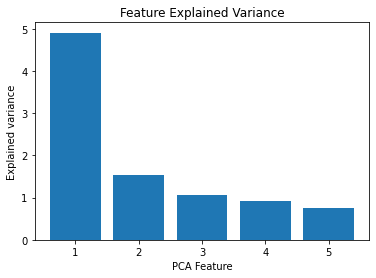

In [34]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

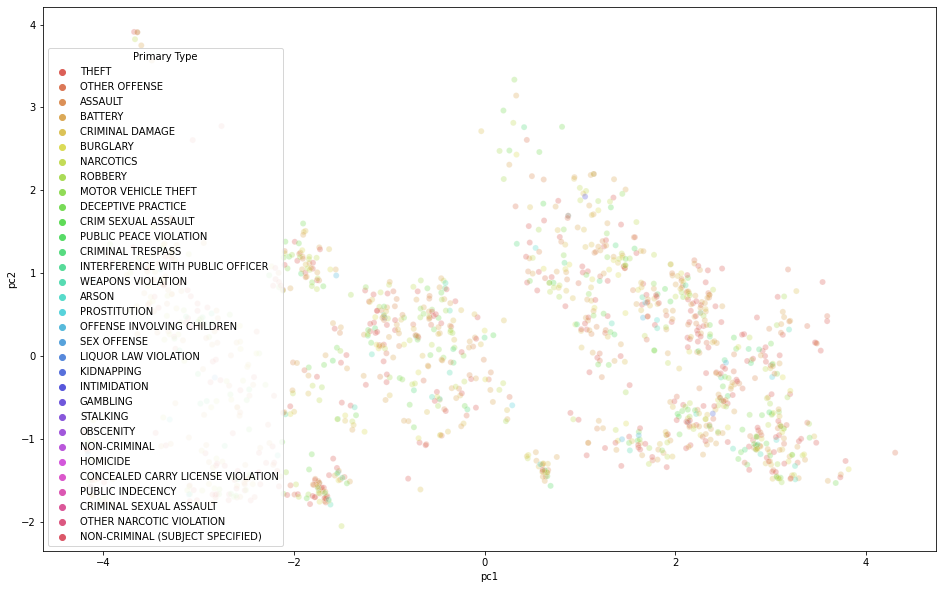

In [28]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=PCA_Df["pc1"], y=PCA_Df["pc2"],
    hue=df_ccr_sample['Primary Type'],
    palette=sns.color_palette("hls", 32),
    #data=PCA_Df,
    legend="full",
    alpha=0.3
)



In [35]:
x_train,x_test,y_train,y_test=train_test_split(X_scaled,Y,test_size=0.2,random_state=117)

In [36]:
#training the model 1st try without PCA
Knnmodel=KNeighborsClassifier()
Knnmodel.fit(x_train,y_train)
y_pred=Knnmodel.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.30635


In [45]:
#training data with the PCA
KnnPCAmodel=KNeighborsClassifier()

x_train_pca,x_test_pca,y_train_pca,y_test_pca=train_test_split(X_PCA,Y,test_size=0.2,random_state=117)

KnnPCAmodel.fit(x_train_pca, y_train_pca)
y_PCA_pred=KnnPCAmodel.predict(x_test_pca)
print(accuracy_score(y_test_pca,y_PCA_pred))


0.3004


## Hyperparameter tunin
### For non PCA X


In [70]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score, val_score = validation_curve(estimator=KNeighborsClassifier(), X=x_train, y=y_train, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


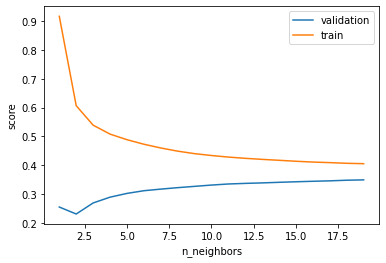

In [71]:
#visualize the best k for n_neighbors
plt.plot(k,val_score.mean(axis=1), label='validation')
plt.plot(k,train_score.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [74]:
#Tuning the hyper Parameters
param_grid = {'n_neighbors': np.arange(1,20),'metric':['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_) # Best parameters apparently
modelknngrid = grid.best_estimator_ #put parameters into model
modelknngrid.score(x_test,y_test) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'euclidean', 'n_neighbors': 14}


0.3432

### For PCA X

In [72]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score_PCA, val_score_PCA = validation_curve(estimator=KNeighborsClassifier(), X=x_train_pca, y=y_train_pca, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


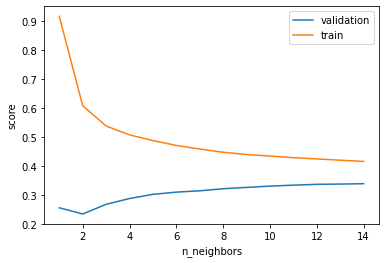

In [73]:
#visualize the best k for n_neighbors
plt.plot(k,val_score_PCA.mean(axis=1), label='validation')
plt.plot(k,train_score_PCA.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [75]:
#Tuning the hyper Parameters
grid.fit(x_train_pca, y_train_pca)

print(grid.best_params_) # Best parameters apparently
modelknngridPCA = grid.best_estimator_ #put parameters into model
modelknngridPCA.score(x_test_pca,y_test_pca) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'manhattan', 'n_neighbors': 14}


0.3429

So basically PCA dimension reduction doesn't improve the model because the data in general is not exploitable to predict a category. But at least the computation is much faster (4 times less)

# **Test with Null values removed**

In [14]:
# df without NULL values.
ccr_no_Null=chicago_crime_records.dropna()
ccr_no_Null.drop(columns=['Location Description','Block','FBI Code','IUCR','Location'],inplace=True)

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [82]:
#using a random sample to work with
ccr_no_Null_sample=ccr_no_Null.sample(100000,random_state=117)

In [83]:
#Splitting the data
XnoNull=ccr_no_Null_sample.drop(columns=['Primary Type'])
YnoNull=ccr_no_Null_sample['Primary Type']

In [84]:
#Some tuning
#Scaling X
scaler=StandardScaler()
XnoNull_scaled=pd.DataFrame(scaler.fit_transform(XnoNull))

In [85]:
XnoNull_PCA = pca.fit_transform(XnoNull_scaled)

In [86]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.50044359 0.14652226 0.10661385]


In [92]:
xnoNull_train,xnoNull_test,ynoNull_train,ynoNull_test=train_test_split(XnoNull_scaled,YnoNull,test_size=0.2,random_state=117)
xnoNull_train_pca,xnoNull_test_pca,ynoNull_train_pca,ynoNull_test_pca=train_test_split(XnoNull_PCA,YnoNull,test_size=0.2,random_state=117)

## Hyperparameter Tuning
### non PCA

In [88]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score_noNull, val_score_noNull = validation_curve(estimator=KNeighborsClassifier(), X=xnoNull_train, y=ynoNull_train, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


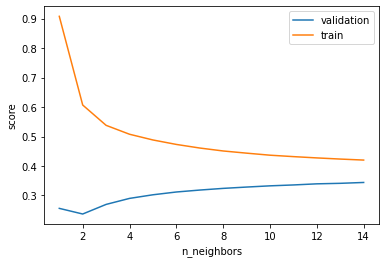

In [89]:
#visualize the best k for n_neighbors
plt.plot(k,val_score_noNull.mean(axis=1), label='validation')
plt.plot(k,train_score_noNull.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [90]:
#Tuning the hyper Parameters
grid.fit(xnoNull_train, ynoNull_train)

print(grid.best_params_) # Best parameters apparently
modelknngridNoNull = grid.best_estimator_ #put parameters into model
modelknngridNoNull.score(xnoNull_test,ynoNull_test) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'manhattan', 'n_neighbors': 14}


0.35045

### With PCA

In [93]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score_noNull_pca, val_score_noNull_pca = validation_curve(estimator=KNeighborsClassifier(), X=xnoNull_train_pca, y=ynoNull_train_pca, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


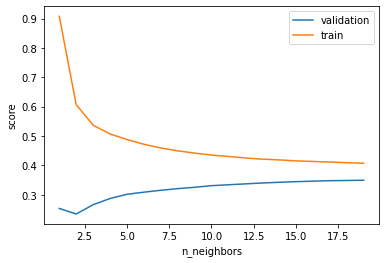

In [94]:
#visualize the best k for n_neighbors
plt.plot(k,val_score_noNull_pca.mean(axis=1), label='validation')
plt.plot(k,train_score_noNull_pca.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [95]:
#Tuning the hyper Parameters
grid.fit(xnoNull_train_pca, ynoNull_train_pca)

print(grid.best_params_) # Best parameters apparently
modelknngridNoNullPCA = grid.best_estimator_ #put parameters into model
modelknngridNoNullPCA.score(xnoNull_test_pca,ynoNull_test_pca) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'euclidean', 'n_neighbors': 14}


0.3464

# **Same model but keeping the "cheat" columns**

In [61]:
# df with NuLL values imputed
df_ccr_cheat=chicago_crime_records.drop(columns=['Location Description','Location'])
df_ccr_cheat["Block Code"]=df_ccr_cheat['Block'].astype('category').cat.codes
df_ccr_cheat['FBI Code_CODE']=df_ccr_cheat['FBI Code'].astype('category').cat.codes
df_ccr_cheat['IUCR_CODE']=df_ccr_cheat['IUCR'].astype('category').cat.codes
df_ccr_cheat.drop(columns=['Block','IUCR','FBI Code'],inplace=True)

In [62]:
#using a smaller sample for faster computation
df_ccr_cheat=df_ccr_cheat.sample(100000,random_state=117)

In [66]:
#Splitting the data
X2=df_ccr_cheat.drop(columns='Primary Type')
Y2=df_ccr_cheat['Primary Type']

#imputing the Null values
imputer.fit(X2)
X2_sample_imputed = imputer.transform(X2)

In [97]:
#scaling the data
X2_scaled=pd.DataFrame(scaler.fit_transform(X2_sample_imputed))

x2_train,x2_test,y2_train,y2_test=train_test_split(X2_scaled,Y2,test_size=0.2,random_state=117)

In [68]:
#training the model 1st try
KnnmodelCheat=KNeighborsClassifier()
KnnmodelCheat.fit(x2_train,y_train)
y_pred_cheat=KnnmodelCheat.predict(x2_test)
print(accuracy_score(y2_test,y_pred_cheat))


0.9119


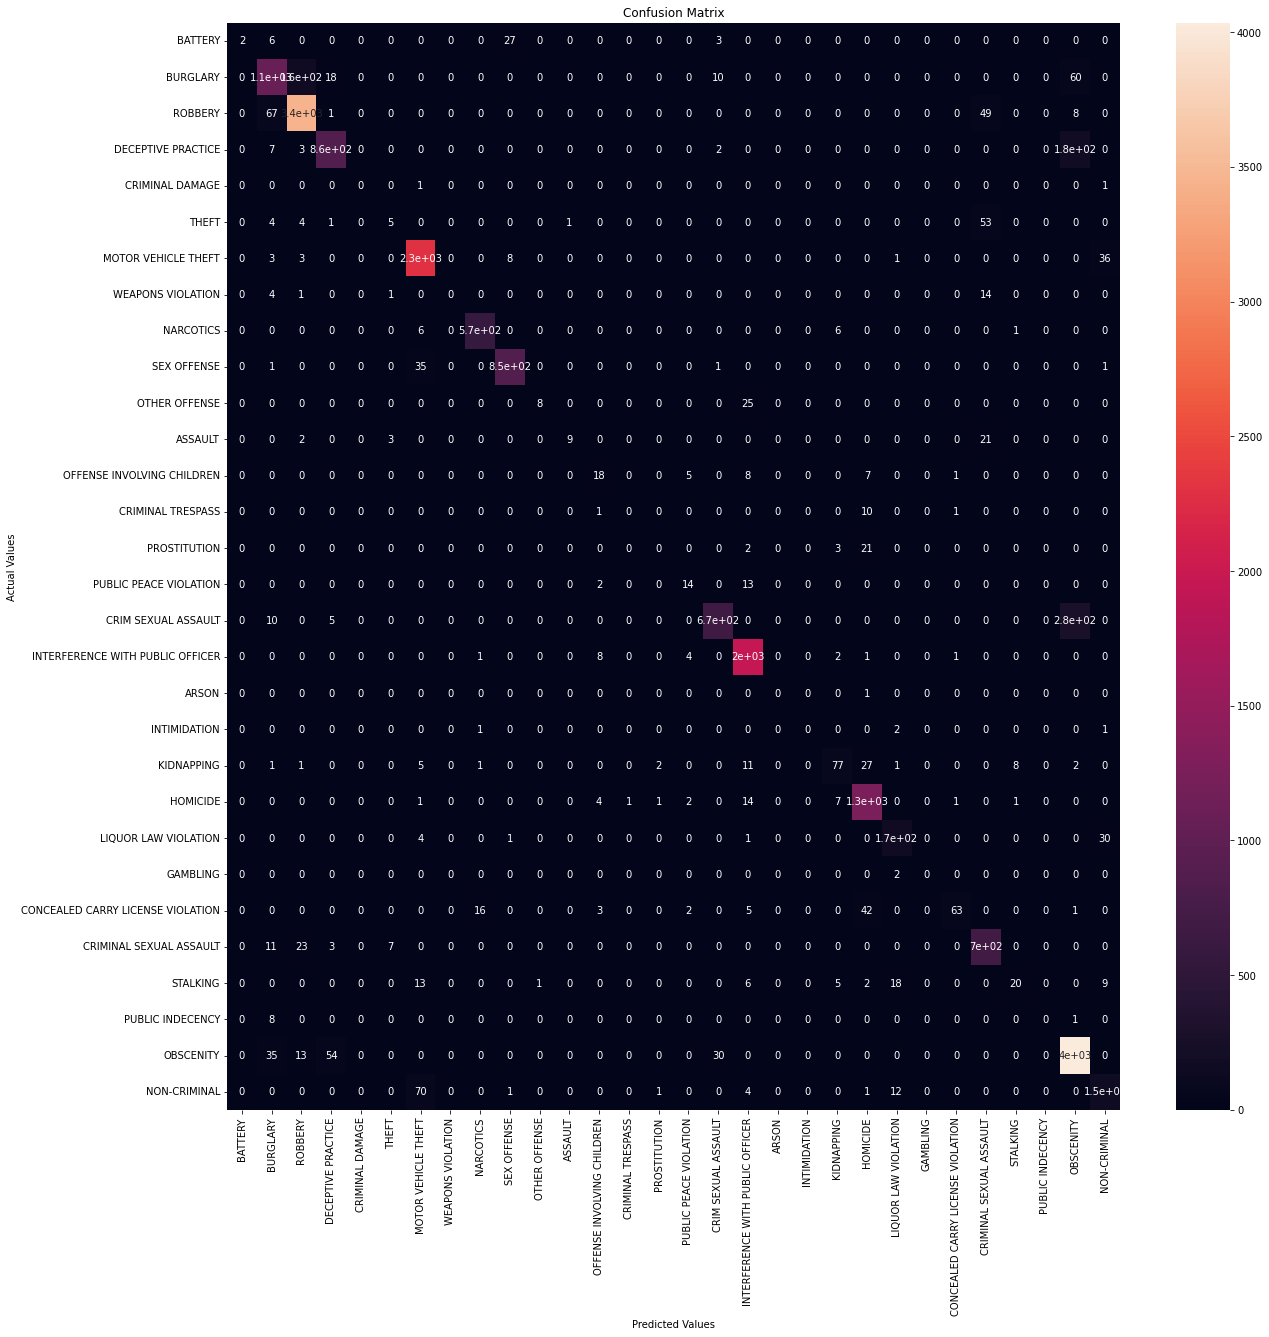

In [69]:
#plotting the confusion matrix
#confusion_matrix_1st_Try=multilabel_confusion_matrix(y_test,y_pred,labels=y_test.unique())
#confusion_matrix_1st_Try
# Creating  a confusion matrix,which compares the y_test and y_pred
cm1 = confusion_matrix(y2_test, y_pred_cheat)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm1_df = pd.DataFrame(cm1,
                     index = y2_test.unique(), 
                     columns = y2_test.unique())
#Plotting the confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm1_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [98]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score_cheat, val_score_cheat = validation_curve(estimator=KNeighborsClassifier(), X=X2_scaled, y=Y2, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


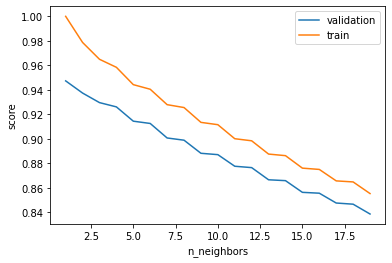

In [99]:
#visualize the best k for n_neighbors
plt.plot(k,val_score_cheat.mean(axis=1), label='validation')
plt.plot(k,train_score_cheat.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [100]:
#Tuning the hyper Parameters
param_grid = {'n_neighbors': np.arange(1,10),'metric':['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(x2_train, y2_train)

print(grid.best_params_) # Best parameters apparently
modelknngridCheat = grid.best_estimator_ #put parameters into model
modelknngridCheat.score(x2_test,y2_test) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'euclidean', 'n_neighbors': 1}


0.9468

We probably have too much features for a KNN model as it doesn't do well with high dimensionnality

## PCA

In [104]:
#applying dimension reduction
pca_cheat = PCA(n_components=4)
X2_PCA = pca_cheat.fit_transform(X2_scaled)

In [105]:
print('Explained variation per principal component: {}'.format(pca_cheat.explained_variance_ratio_))

Explained variation per principal component: [0.38413029 0.16306318 0.12488373 0.07814379]


In [106]:
x2_train_pca,x2_test_pca,y2_train_pca,y2_test_pca=train_test_split(X2_PCA,Y2,test_size=0.2,random_state=117)

In [107]:
#validation curve for the non PCA data
k = np.arange(1, 20)
train_score_cheat_pca, val_score_cheat_pca = validation_curve(estimator=KNeighborsClassifier(), X=X2_PCA, y=Y2, param_name='n_neighbors', param_range=k)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


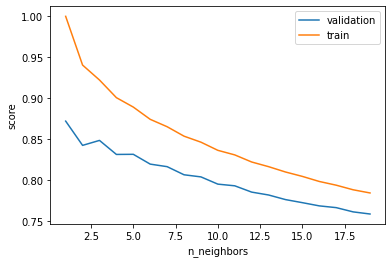

In [108]:
#visualize the best k for n_neighbors
plt.plot(k,val_score_cheat_pca.mean(axis=1), label='validation')
plt.plot(k,train_score_cheat_pca.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [109]:
#Tuning the hyper Parameters
param_grid = {'n_neighbors': np.arange(1,10),'metric':['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(x2_train_pca, y2_train_pca)

print(grid.best_params_) # Best parameters apparently
modelknngridCheat = grid.best_estimator_ #put parameters into model
modelknngridCheat.score(x2_test_pca,y2_test_pca) # score the model

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'manhattan', 'n_neighbors': 1}


0.8761